In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pandas as pd
import os
from collections import defaultdict
from utils import json_load

file_path = (
    "/ssddata/tongyx/projects/deita-domain/DEITA-Domain/eval-results/eval-results.csv"
)
eval_results_dir = "eval-results"

In [29]:
model2bench_metric_lists = {}
choice_benchs = ["aqua", "mmlu_mathematics", "sat"]

for model_eval_dirname in os.listdir(eval_results_dir):
    model_eval_dirpath = os.path.join(eval_results_dir, model_eval_dirname)

    if not os.path.isdir(model_eval_dirpath):
        continue
    print(model_eval_dirname)
    # break

    model_bench_metric_lists = []
    model_eval_results_root = os.path.join(model_eval_dirpath, "results")
    eval_results_filenames = os.listdir(model_eval_results_root)

    cot_eval_results_filenames = [
        filename for filename in eval_results_filenames if "cot" in filename
    ]
    cot_eval_results_filenames.sort()
    pot_eval_results_filenames = [
        filename.replace("cot", "pot")
        if filename.replace("cot", "pot") in eval_results_filenames
        else None
        for filename in cot_eval_results_filenames
    ]

    for cot_filename, pot_filename in zip(
        cot_eval_results_filenames, pot_eval_results_filenames
    ):
        bench_name = cot_filename.replace("-cot", "").split(".json")[0]
        cot_eval_results = json_load(
            os.path.join(model_eval_results_root, cot_filename)
        )

        pot_eval_results = (
            json_load(os.path.join(model_eval_results_root, pot_filename))
            if pot_filename is not None
            else None
        )

        nsamples = len(cot_eval_results)

        metric_indices = {
            "nsamples": set(),
            "cot_direct_correct": set(),
            "cot_err": set(),
            "cot_match": set(),
            "cot_match_err": set(),
            "cot_correct": set(),
            "pot_direct_correct": set(),
            "pot_err": set(),
            "pot_match": set(),
            "pot_match_err": set(),
            "pot_correct": set(),
            "all_correct": set(),
            "any_correct": set(),
            "fallback_correct": set(),
        }

        field2level2metrics = {}

        for i in range(nsamples):
            cot_res = cot_eval_results[i]
            cot_match_err = cot_res.get("matching_err")
            cot_match = cot_match_err is not None

            cot_ans = cot_res["ans"]
            cot_correct = cot_res["correct"]

            metric_indices["nsamples"].add(i)
            if cot_match:
                metric_indices["cot_match"].add(i)
                if cot_match_err:
                    metric_indices["cot_match_err"].add(i)
            if cot_correct:
                metric_indices["cot_correct"].add(i)
            if cot_res["err"]:
                metric_indices["cot_err"].add(i)

            if pot_eval_results is not None:
                pot_res = pot_eval_results[i]
                pot_match_err = pot_res.get("matching_err")
                pot_match = pot_match_err is not None

                pot_ans = pot_res.get("ans")
                if pot_ans is not None:
                    pot_correct = pot_res["correct"]

                    if pot_match:
                        metric_indices["pot_match"].add(i)
                        if pot_match_err:
                            metric_indices["pot_match_err"].add(i)
                    if pot_correct:
                        metric_indices["pot_correct"].add(i)
                        metric_indices["fallback_correct"].add(i)

                    if pot_res["err"]:
                        metric_indices["pot_err"].add(i)
                        if cot_correct:
                            metric_indices["fallback_correct"].add(i)

        def calculate_sets_from_stats(metric_indices):
            metric_indices["cot_direct_correct"] = metric_indices[
                "cot_correct"
            ].difference(metric_indices["cot_match"])
            metric_indices["pot_direct_correct"] = metric_indices[
                "pot_correct"
            ].difference(metric_indices["pot_match_err"])
            metric_indices["all_correct"] = metric_indices["cot_correct"].intersection(
                metric_indices["pot_correct"]
            )
            metric_indices["any_correct"] = metric_indices["cot_correct"].union(
                metric_indices["pot_correct"]
            )

        calculate_sets_from_stats(metric_indices)

        def calculate_metrics_from_stats(bench_name, metric_indices):
            bench_metric_list = {
                "bench_name": bench_name,
            }
            rate_fallback_correct = len(metric_indices["fallback_correct"]) / nsamples
            rate_cot_direct_correct = (
                len(metric_indices["cot_direct_correct"]) / nsamples
            )
            rate_pot_direct_correct = (
                len(metric_indices["pot_direct_correct"]) / nsamples
            )
            rate_cot_correct = len(metric_indices["cot_correct"]) / nsamples
            rate_pot_correct = len(metric_indices["pot_correct"]) / nsamples
            rate_all_correct = len(metric_indices["all_correct"]) / nsamples
            rate_any_correct = len(metric_indices["any_correct"]) / nsamples
            rate_cot_err = len(metric_indices["cot_err"]) / nsamples
            rate_pot_err = len(metric_indices["pot_err"]) / nsamples
            rate_cot_match = len(metric_indices["cot_match"]) / nsamples
            rate_pot_match = len(metric_indices["pot_match"]) / nsamples
            rate_cot_match_err = len(metric_indices["cot_match_err"]) / nsamples
            rate_pot_match_err = len(metric_indices["pot_match_err"]) / nsamples

            bench_metric_list.update(
                {
                    "nsamples": nsamples,
                    "rate_fallback_correct": rate_fallback_correct,
                    "rate_cot_correct": rate_cot_correct,
                    "rate_pot_correct": rate_pot_correct,
                    "rate_all_correct": rate_all_correct,
                    "rate_any_correct": rate_any_correct,
                    "rate_cot_err": rate_cot_err,
                    "rate_pot_err": rate_pot_err,
                }
            )
            if bench_name in choice_benchs:
                bench_metric_list.update(
                    {
                        "rate_cot_direct_correct": rate_cot_direct_correct,
                        "rate_pot_direct_correct": rate_pot_direct_correct,
                        "rate_cot_match": rate_cot_match,
                        "rate_cot_match_err": rate_cot_match_err,
                        "rate_pot_match": rate_pot_match,
                        "rate_pot_match_err": rate_pot_match_err,
                    }
                )
            return bench_metric_list

        # logging.info(f"batch_info = {bench_metric_list}")
        model_bench_metric_lists.append(
            calculate_metrics_from_stats(bench_name, metric_indices)
        )

    model2bench_metric_lists[model_eval_dirname] = model_bench_metric_lists

llemma-7b-math-instruct-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs3-maxlen512--checkpoint-6144
llemma-7b-math-instruct-core-diffi-aware-pre-b0-w1-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-4651
llemma-7b-math-instruct-core-diffi-aware-pre-b1-w0.5-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-3195
llemma-7b-math-instruct-core-diffi-aware-pre-b0-w2-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-9302
llemma-7b-math-instruct-core-diffi-aware-pre-b1-w1-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-5970
llemma-7b-math-instruct-core-diffi-aware-pre-b1-w2-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-10621
llemma-7b-math-instruct-core-diffi-aware-pre-b2-w0.5-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-4514
llemma-7b-math-instruct-core-diffi-aware-pre-b2-w1-bs128-gas1-lr2e-5-wd0-warm

In [30]:
print(f"all models: {list(model2bench_metric_lists.keys())}")

for info in model2bench_metric_lists.values():
    if "rate_cot_direct_correct" not in info[0]:
        continue
    all_metrics = [
        metric.replace("rate_", "")
        for metric in info[0].keys()
        if metric.startswith("rate_")
    ]
    break
print(f"all metrics: {all_metrics}")

model_id2line = {}
for model_id, bench_metric_lists in model2bench_metric_lists.items():
    line = {}
    for bench_metric_list in bench_metric_lists:
        bench_name = bench_metric_list["bench_name"]
        for metric in all_metrics:
            metric_name = f"{bench_name}_{metric}"
            rate_name = f"rate_{metric}"
            line[metric_name] = bench_metric_list.get(rate_name)
    model_id2line[model_id] = line

    # print(model_id2bench_metric_list[model_id])
data = pd.DataFrame(model_id2line).T.sort_index()
data.index.name = "model_id"
print(data)

all models: ['llemma-7b-math-instruct-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs3-maxlen512--checkpoint-6144', 'llemma-7b-math-instruct-core-diffi-aware-pre-b0-w1-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-4651', 'llemma-7b-math-instruct-core-diffi-aware-pre-b1-w0.5-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-3195', 'llemma-7b-math-instruct-core-diffi-aware-pre-b0-w2-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-9302', 'llemma-7b-math-instruct-core-diffi-aware-pre-b1-w1-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-5970', 'llemma-7b-math-instruct-core-diffi-aware-pre-b1-w2-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-10621', 'llemma-7b-math-instruct-core-diffi-aware-pre-b2-w0.5-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs1-maxlen512--checkpoint-4514', 'llemma-7b-math-instruct-core-diffi-aware-p

In [31]:
# unify into extract_model_info(model_id, info_pattern, info_type)
def extract_model_info(model_id, info_pattern, info_type):
    info_match = re.search(info_pattern, model_id)
    info = info_type(info_match.group(1)) if info_match else None
    return info


data.reset_index(inplace=True)

data["w"] = data["model_id"].apply(
    lambda x: extract_model_info(x, r"-w([\d\.]+)-", float)
)
data["b"] = data["model_id"].apply(lambda x: extract_model_info(x, r"-b(\d+)-", int))
data["nepochs"] = data["model_id"].apply(
    lambda x: extract_model_info(x, r"-epochs(\d+)-", int)
)
data["nsteps"] = data["model_id"].apply(
    lambda x: extract_model_info(x, r"--checkpoint-(\d+)-", int)
)
data["lr"] = data["model_id"].apply(
    lambda x: extract_model_info(x, r"-lr([-e\d\.]+)-", float)
)

# Filter out rows where w or b are None (i.e., not containing 'b{num}' and 'w{num}')
filtered_data = data.dropna(subset=["w", "b"])
# Filter out rows where nepochs > 1
filtered_data = filtered_data[filtered_data["nepochs"] == 1]
# Filter out rows where lr != 2e-5
filtered_data = filtered_data[filtered_data["lr"] == 2e-5]

# Barplot with Hue: Score / Decoding / w / b

In [36]:
def bench_barplot_w_hue(
    bench_name,
    interested_scores,
    plot_titles,
    filtered_data,
    show_num=False,
    baseline_model_id="llemma-7b-math-instruct-bs128-gas1-lr2e-5-wd0-warmratio0.03-sched-cosine-epochs3-maxlen512--checkpoint-6144",
):
    # Keep only the necessary columns for the analysis
    columns_of_interest = [
        "model_id",
        *interested_scores,
        "w",
        "b",
    ]
    filtered_data = filtered_data[columns_of_interest]

    # Find the baseline model
    baseline_data = data[data["model_id"] == baseline_model_id]

    # Check the first few rows of the filtered data and the baseline data
    filtered_data.head(), baseline_data[columns_of_interest].head()

    # Extract baseline scores
    baseline_scores = baseline_data.iloc[0][interested_scores]

    # Convert 'b' values to strings to ensure proper handling in the legend
    filtered_data["b"] = filtered_data["b"].astype(str)

    # Sorting the filtered data by 'w' and 'b' for consistent plotting
    sorted_filtered_data = filtered_data.sort_values(
        by=["w", "b"], ascending=[True, True]
    )

    if show_num:
        print(sorted_filtered_data.drop(columns=["model_id"]))

    # Define the correct order for 'b' values, which will be used in the plot and legend
    b_order = np.sort(sorted_filtered_data["b"].unique())

    # print(f"b_order: {b_order}")

    # Set up the matplotlib figure
    plt.figure(figsize=(20, 10))

    y_all_min = min(
        [baseline_scores[score] for score in interested_scores]
        + list(sorted_filtered_data[interested_scores].min())
    )

    y_all_max = max(
        [baseline_scores[score] for score in interested_scores]
        + list(sorted_filtered_data[interested_scores].max())
    )

    # Plot each score in a subplot
    for i, score in enumerate(interested_scores):
        plt.subplot(2, 2, i + 1)

        # Create the plot
        ax = sns.barplot(
            x="w",
            y=score,
            hue="b",
            data=sorted_filtered_data,
            palette=sns.color_palette("Blues", len(b_order)),
            hue_order=b_order,
        )

        # Remove the legend of each subplot
        ax.get_legend().remove()

        y_score_min = min(baseline_scores[score], sorted_filtered_data[score].min())
        y_score_max = max(baseline_scores[score], sorted_filtered_data[score].max())

        # unify the y axis
        if "datasets" not in bench_name.lower():
            plt.ylim(max(y_all_min - 0.1, 0), min(y_all_max + 0.1, 1))
        else:
            plt.ylim(max(y_score_min - 0.1, 0), min(y_score_max + 0.1, 1))

        # Plot baseline
        plt.axhline(y=baseline_scores[score], color="r", linestyle="--", linewidth=2)

        # Set the title
        plt.title(plot_titles[i])
        plt.xlabel("w")
        plt.ylabel("Score")

    # Create legend for the entire figure, sorted by 'b'
    handles, labels = plt.gca().get_legend_handles_labels()
    sorted_handles = [x for _, x in sorted(zip(map(float, labels), handles))]
    sorted_labels = sorted(map(float, labels))
    plt.figlegend(sorted_handles, sorted_labels, title="b", loc="right")
    # fig title
    plt.suptitle(bench_name, fontsize=16)
    # Adjust layout

    plt.tight_layout()

    # Show the plot
    plt.show()
    # save the plot as pdf
    # plt.savefig("eval-results.pdf", bbox_inches="tight", dpi=300)

/tmp/ipykernel_2066240/1900538028.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["b"] = filtered_data["b"].astype(str)
/ssddata/tongyx/miniconda3/envs/def/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ssddata/tongyx/miniconda3/envs/def/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ssddata/tongyx/miniconda3/envs/def/lib/python3.11/site-packa

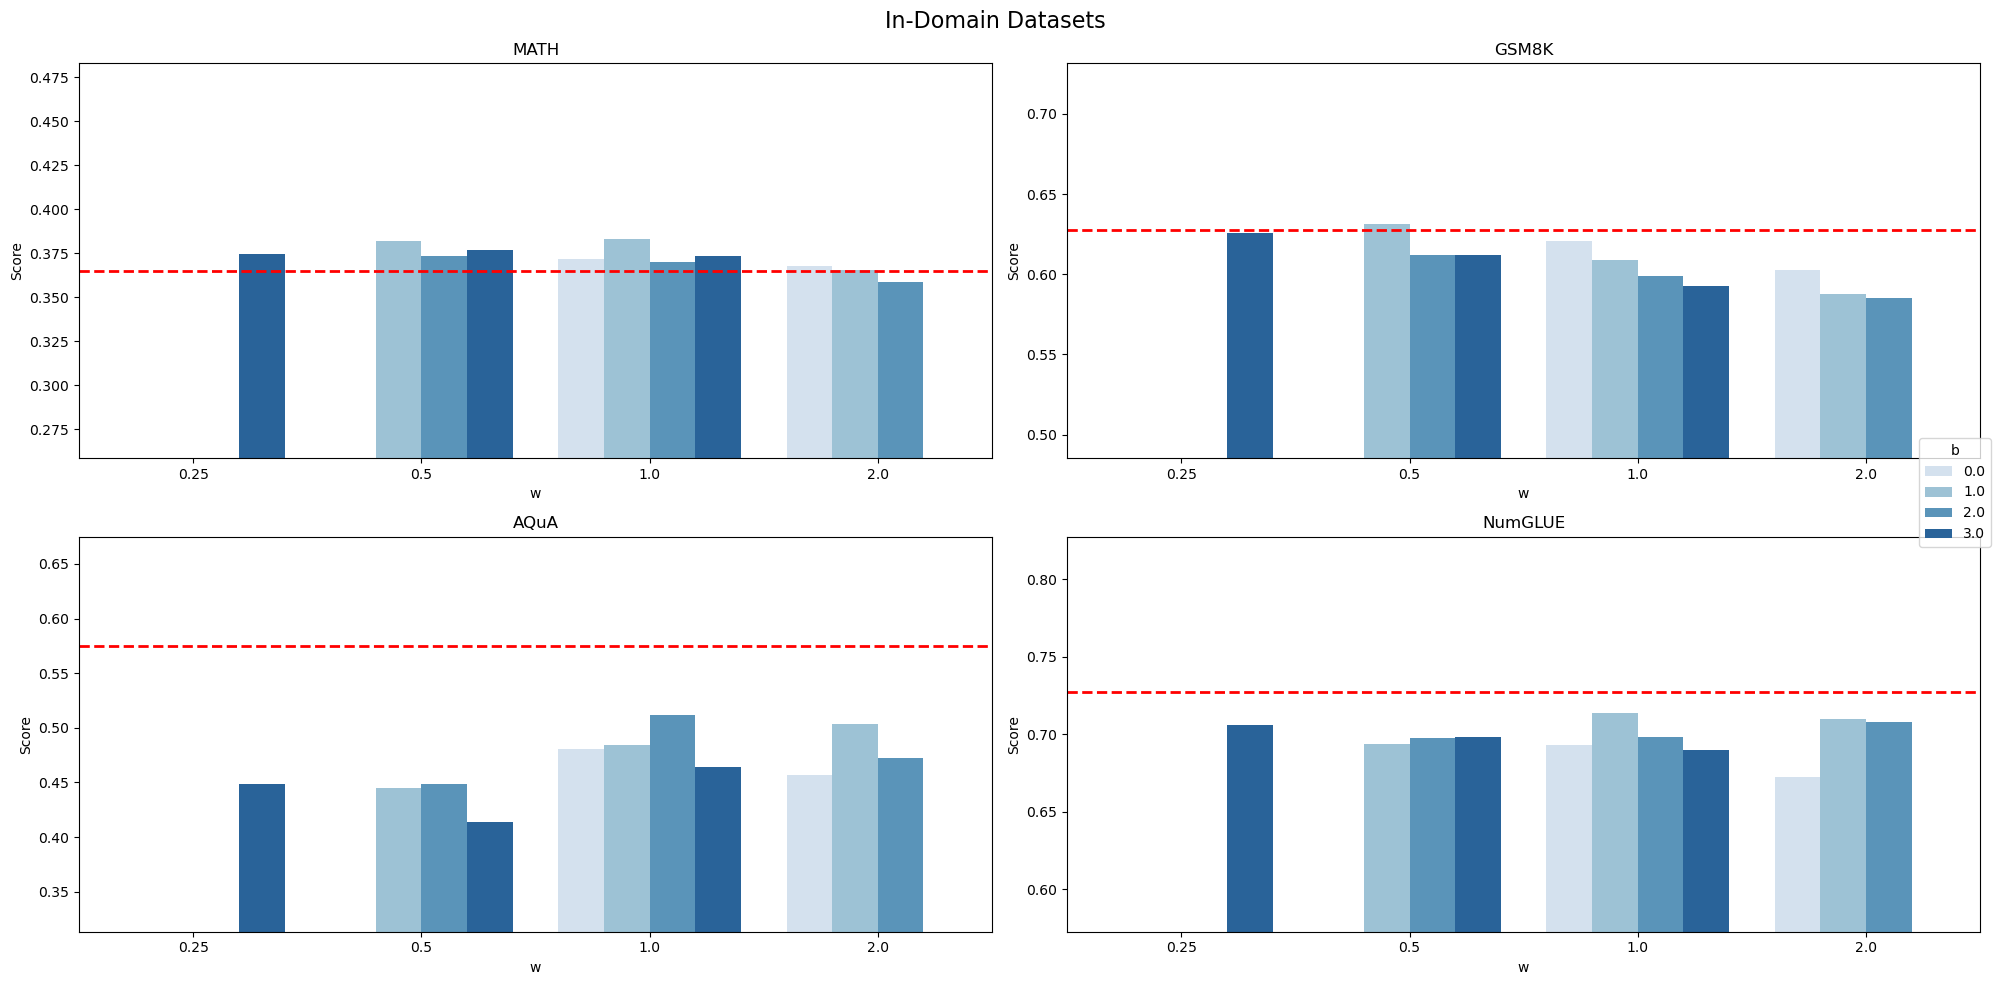

In [33]:
bench_name = "In-Domain Datasets"
interested_scores = [
    "math_fallback_correct",
    "gsm8k_fallback_correct",
    "aqua_fallback_correct",
    "numglue_fallback_correct",
]
plot_titles = ["MATH", "GSM8K", "AQuA", "NumGLUE"]

bench_barplot_w_hue(bench_name, interested_scores, plot_titles, filtered_data)

/tmp/ipykernel_2066240/1900538028.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["b"] = filtered_data["b"].astype(str)
/ssddata/tongyx/miniconda3/envs/def/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ssddata/tongyx/miniconda3/envs/def/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ssddata/tongyx/miniconda3/envs/def/lib/python3.11/site-packa

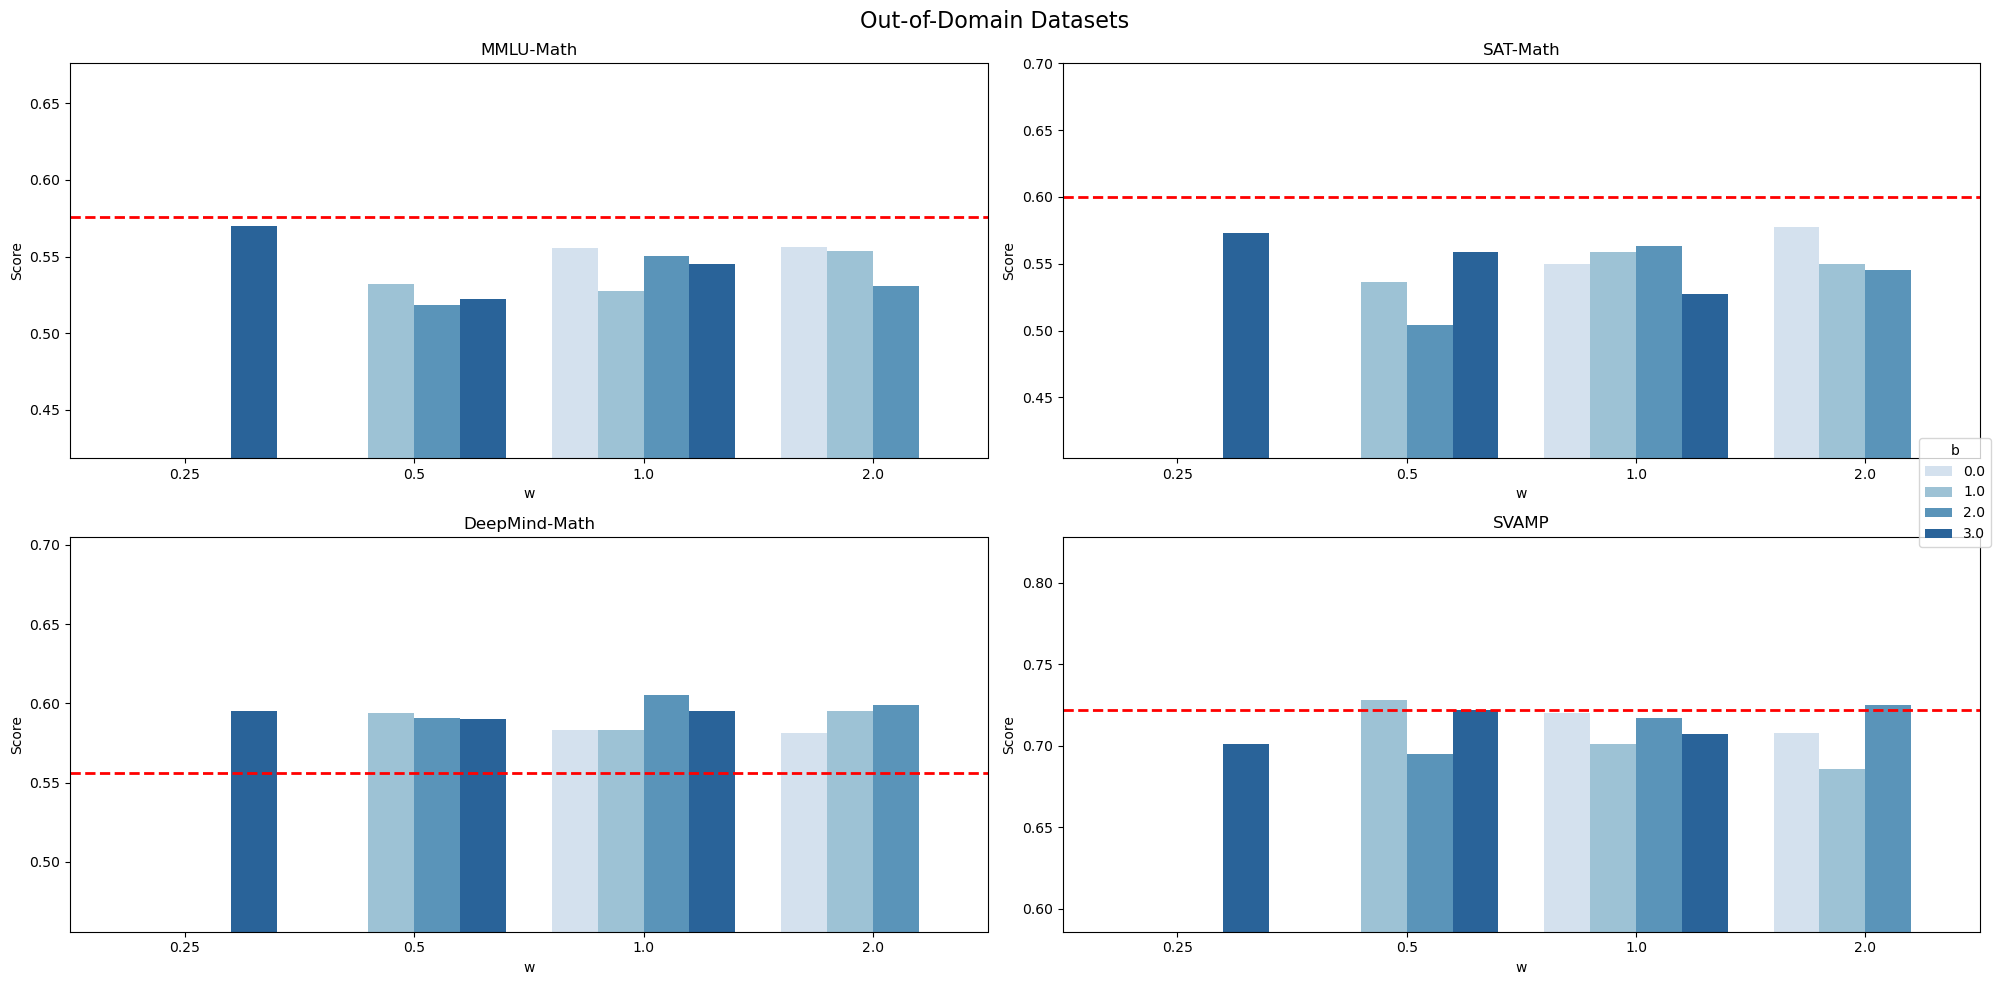

In [34]:
bench_name = "Out-of-Domain Datasets"
interested_scores = [
    "mmlu_mathematics_fallback_correct",
    "sat_fallback_correct",
    "deepmind_fallback_correct",
    "svamp_fallback_correct",
]
plot_titles = ["MMLU-Math", "SAT-Math", "DeepMind-Math", "SVAMP"]

bench_barplot_w_hue(bench_name, interested_scores, plot_titles, filtered_data)

## Barplot w/ Hue: Score - Decoding

/tmp/ipykernel_2066240/1900538028.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["b"] = filtered_data["b"].astype(str)
/ssddata/tongyx/miniconda3/envs/def/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ssddata/tongyx/miniconda3/envs/def/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/ssddata/tongyx/miniconda3/envs/def/lib/python3.11/site-packa

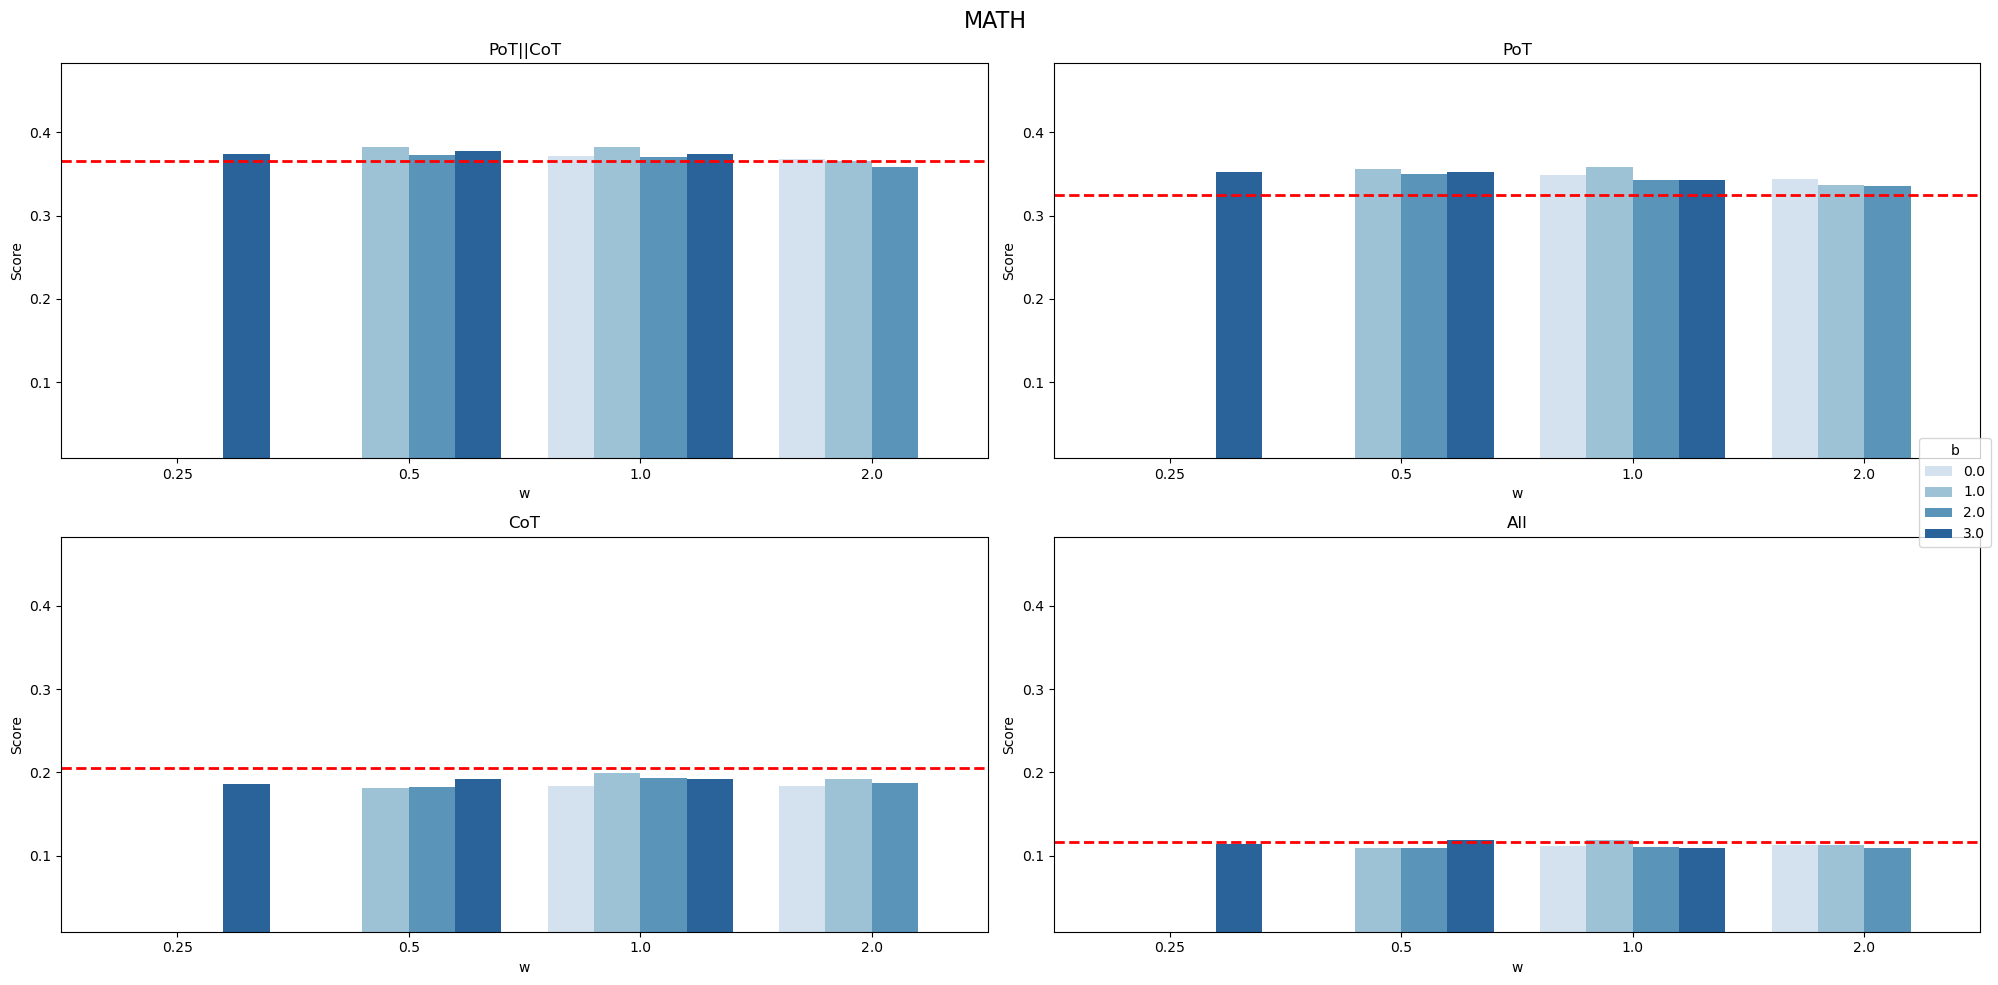

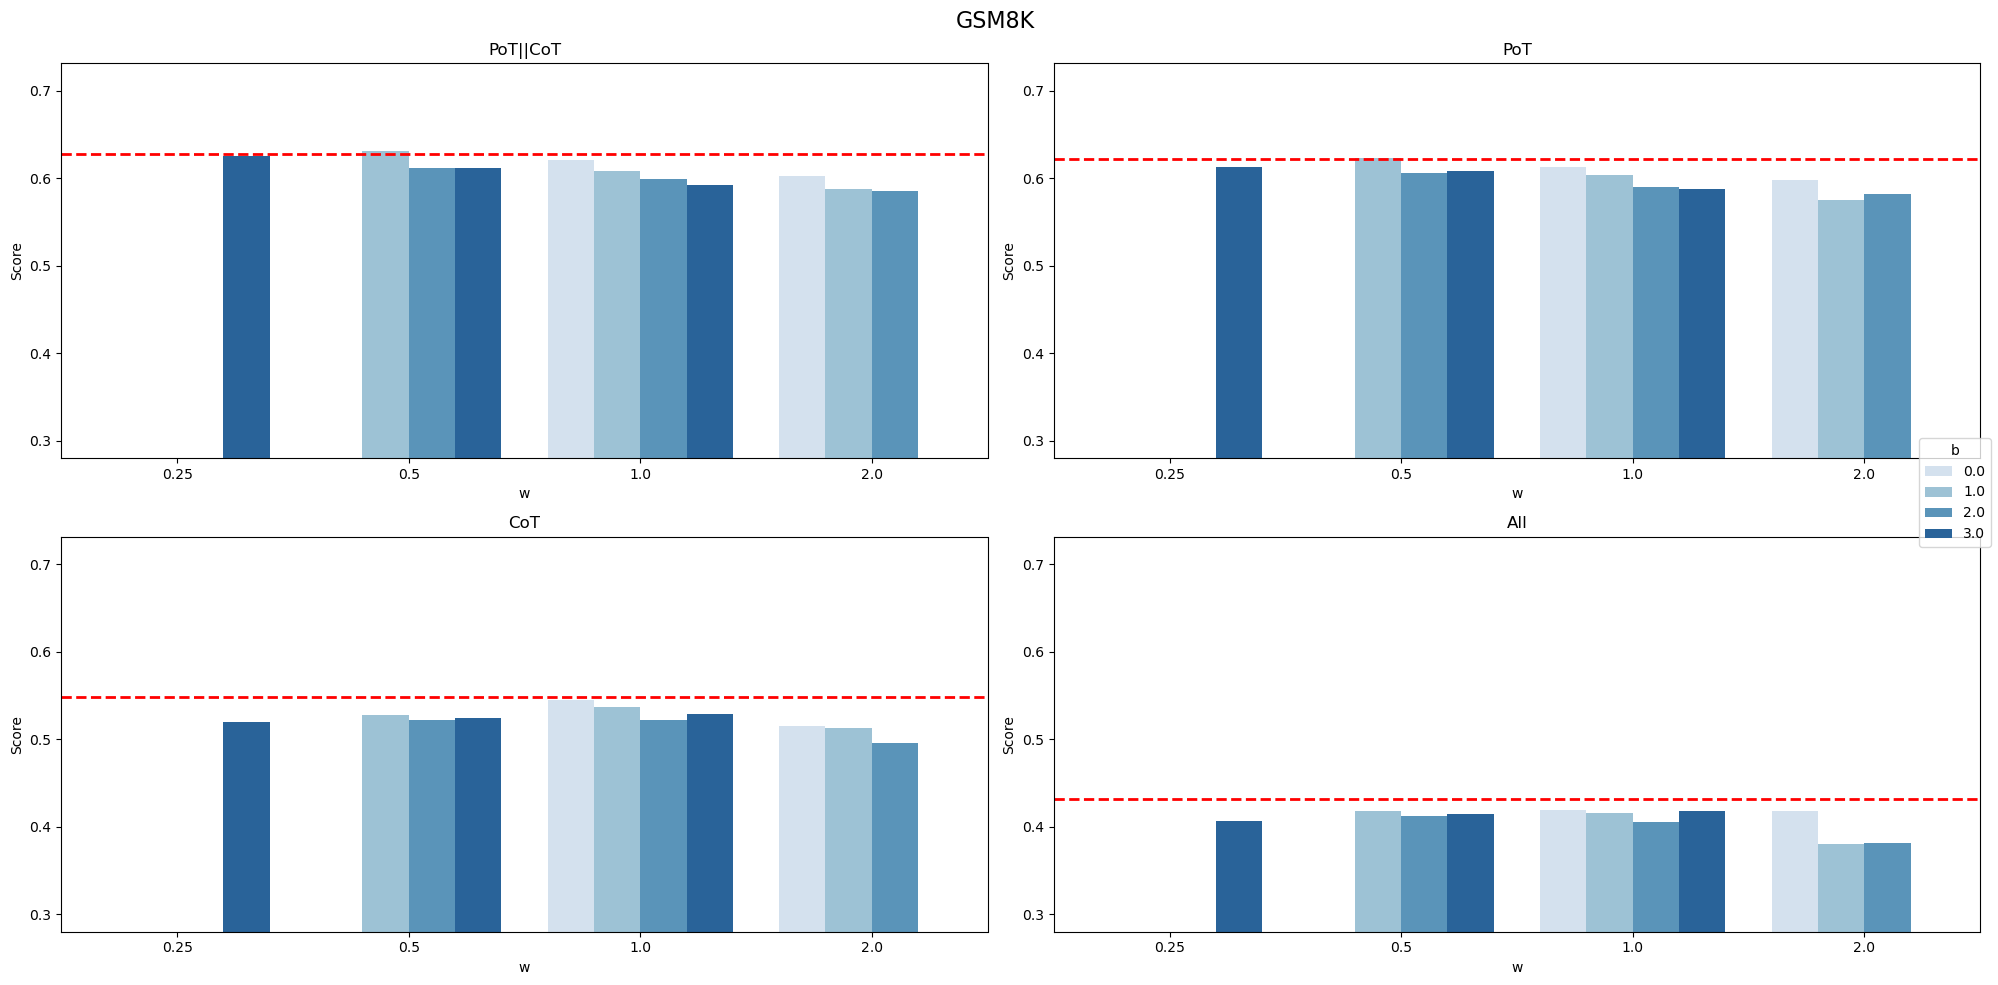

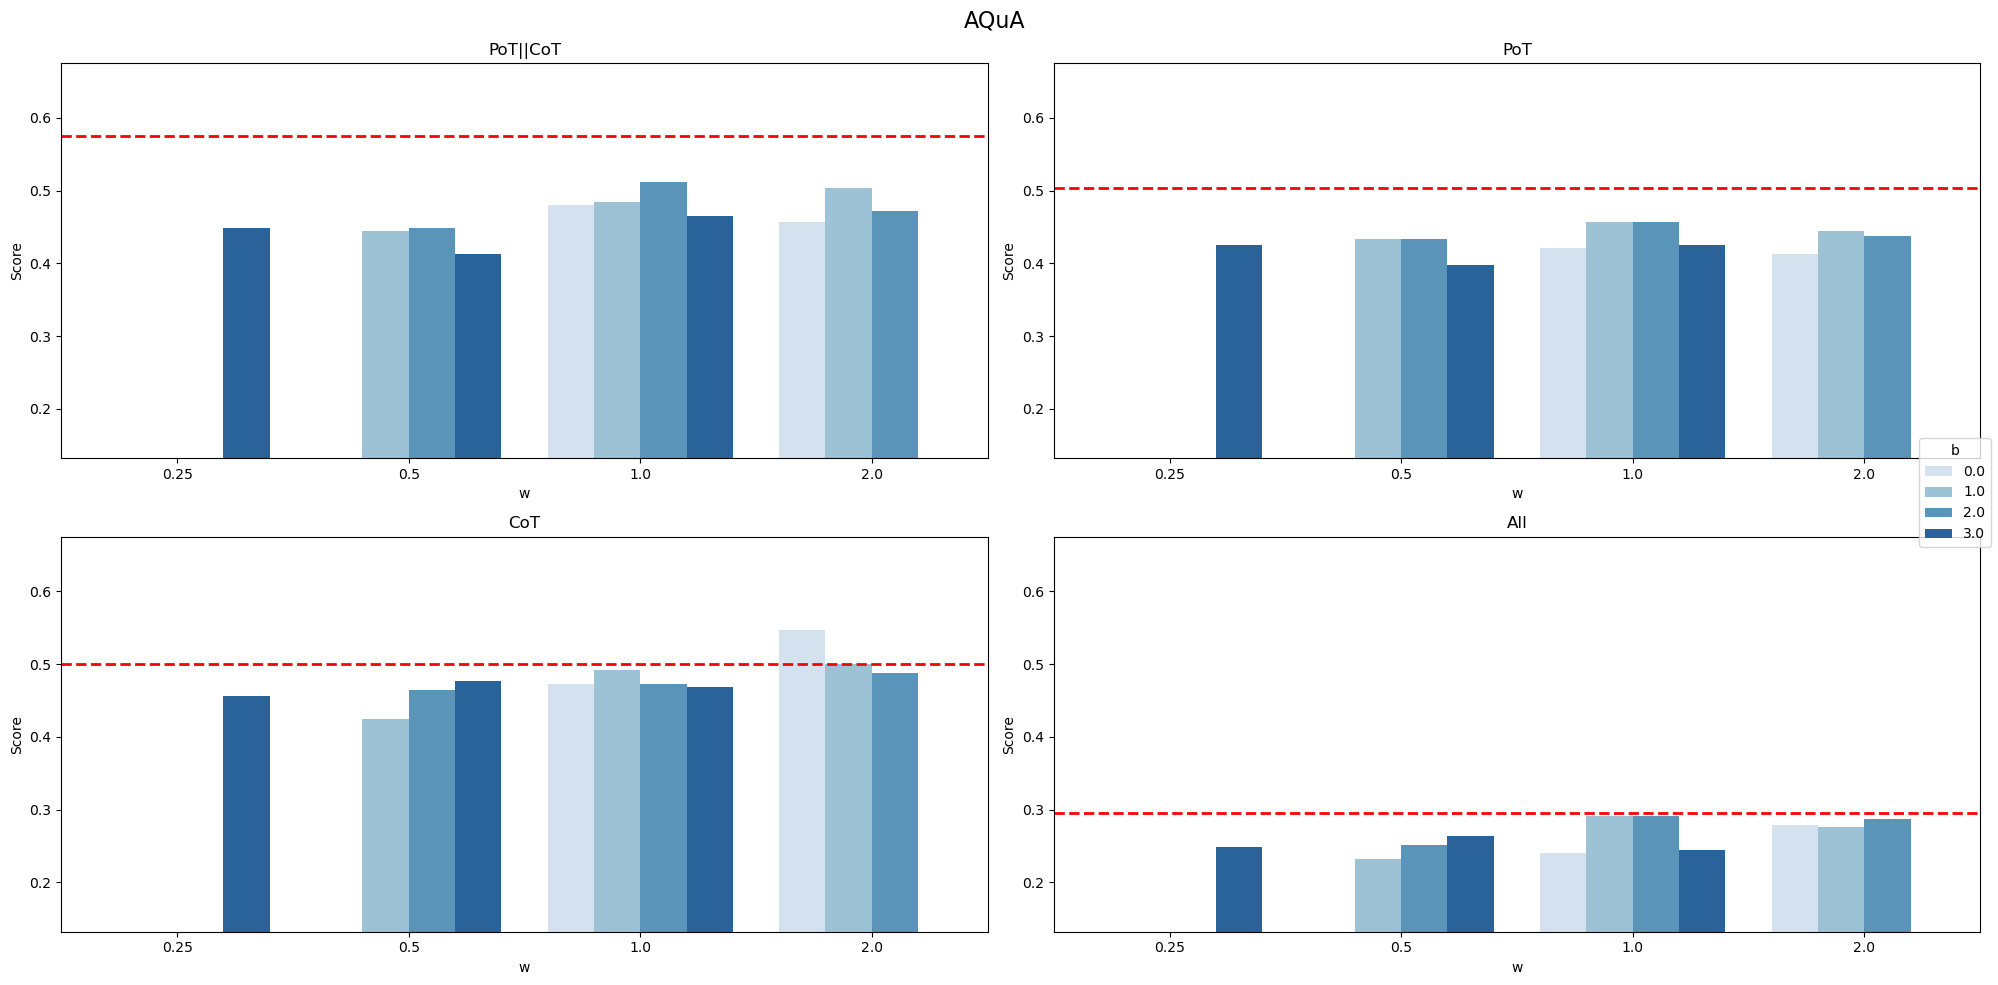

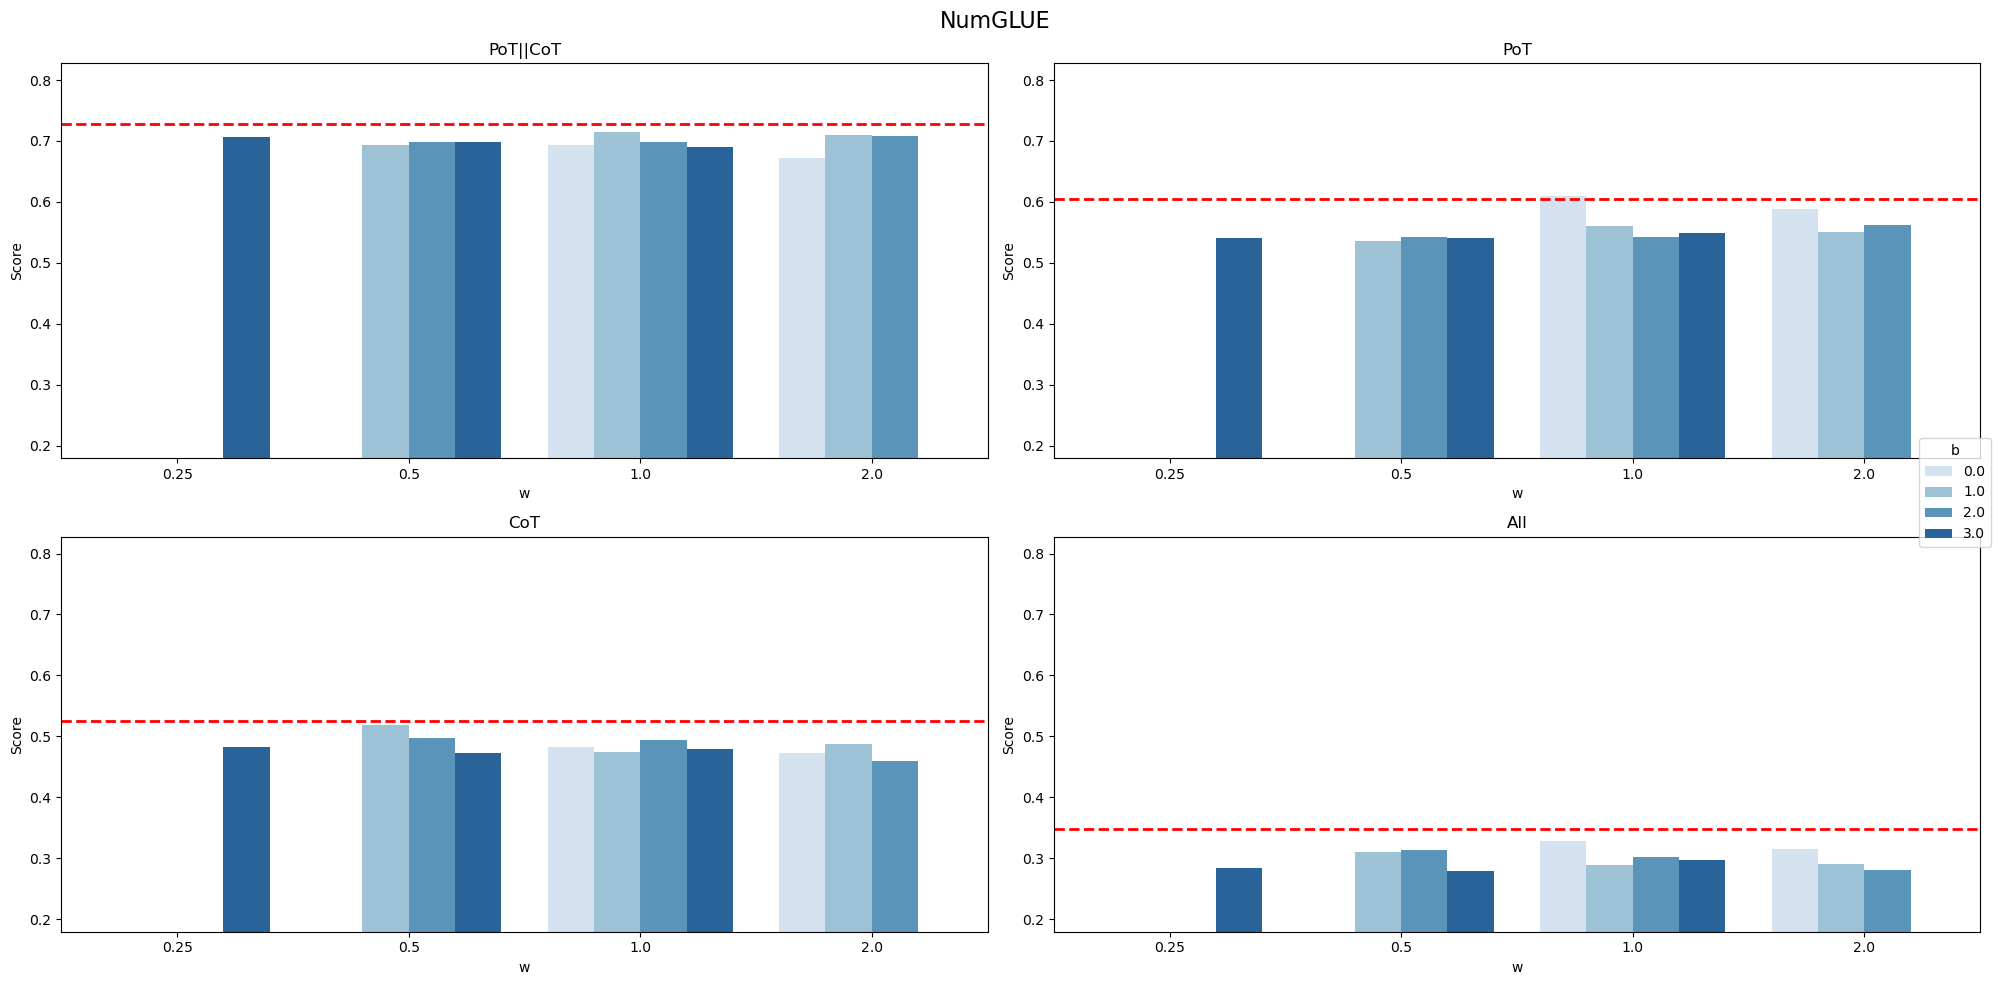

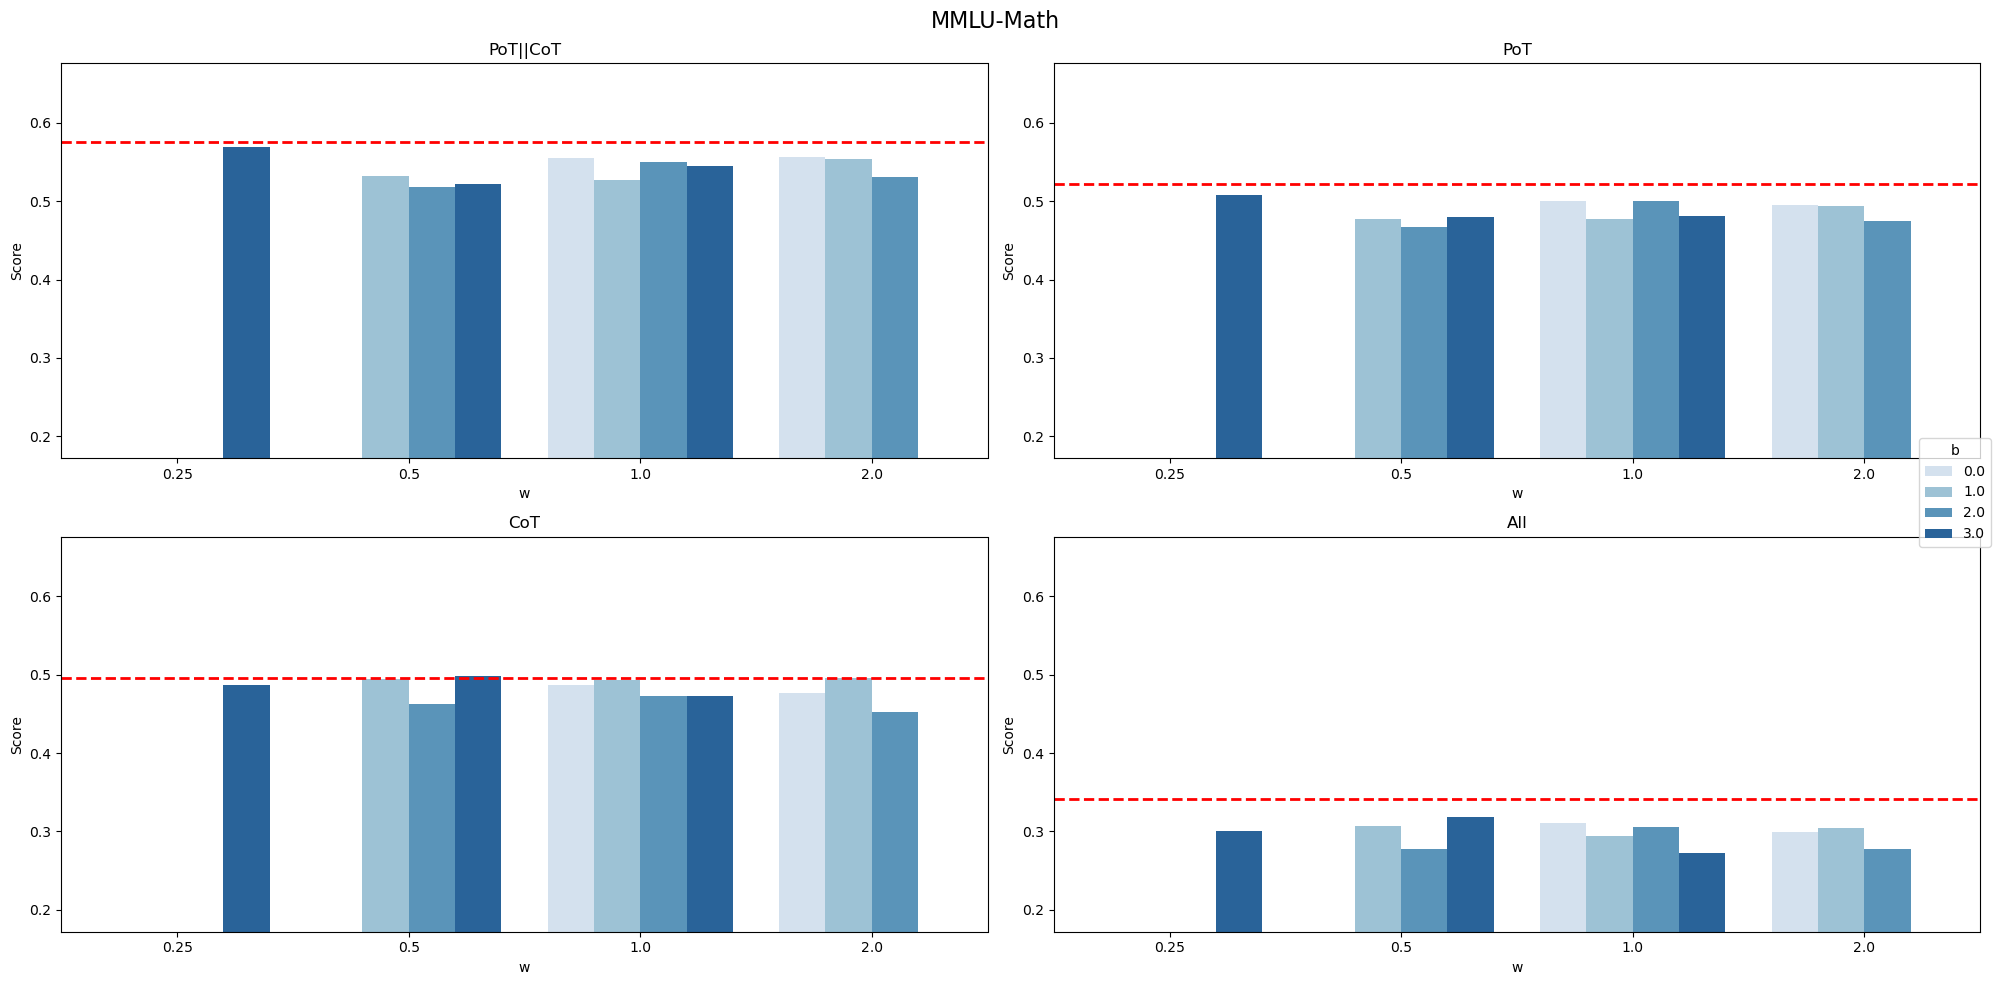

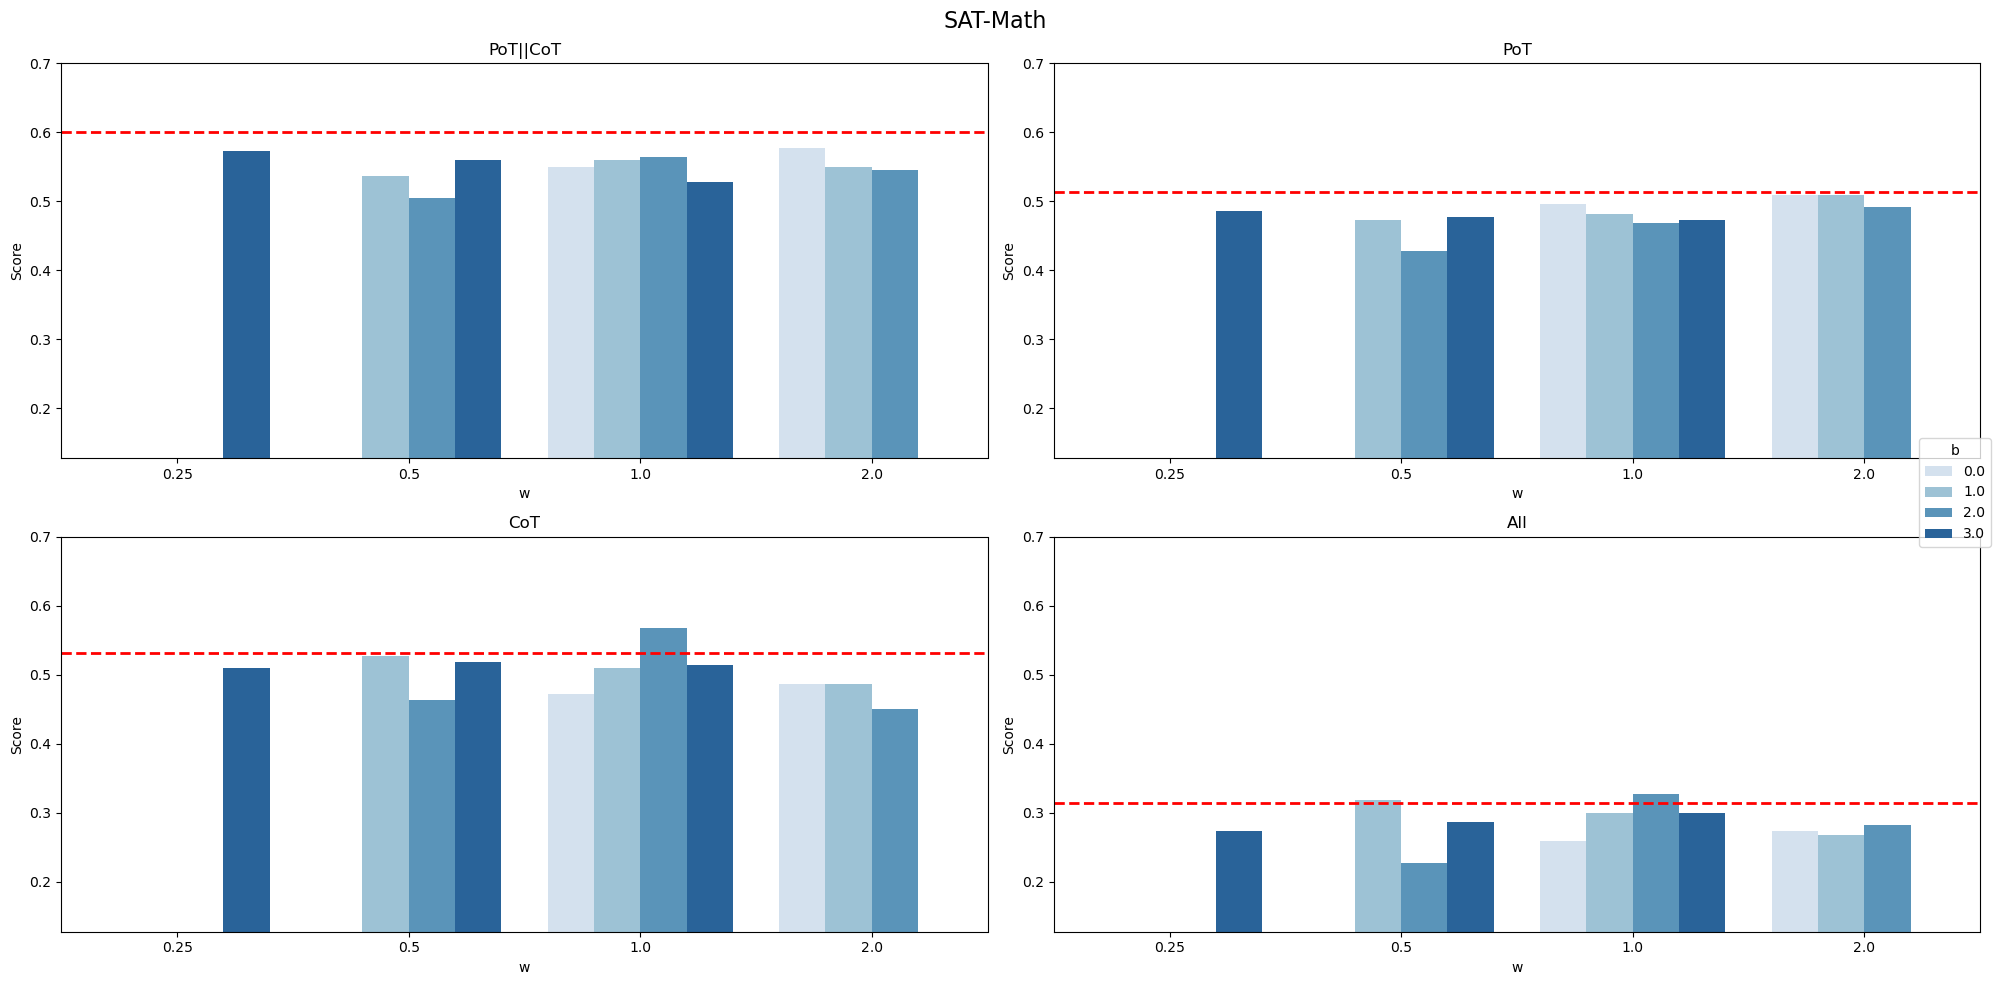

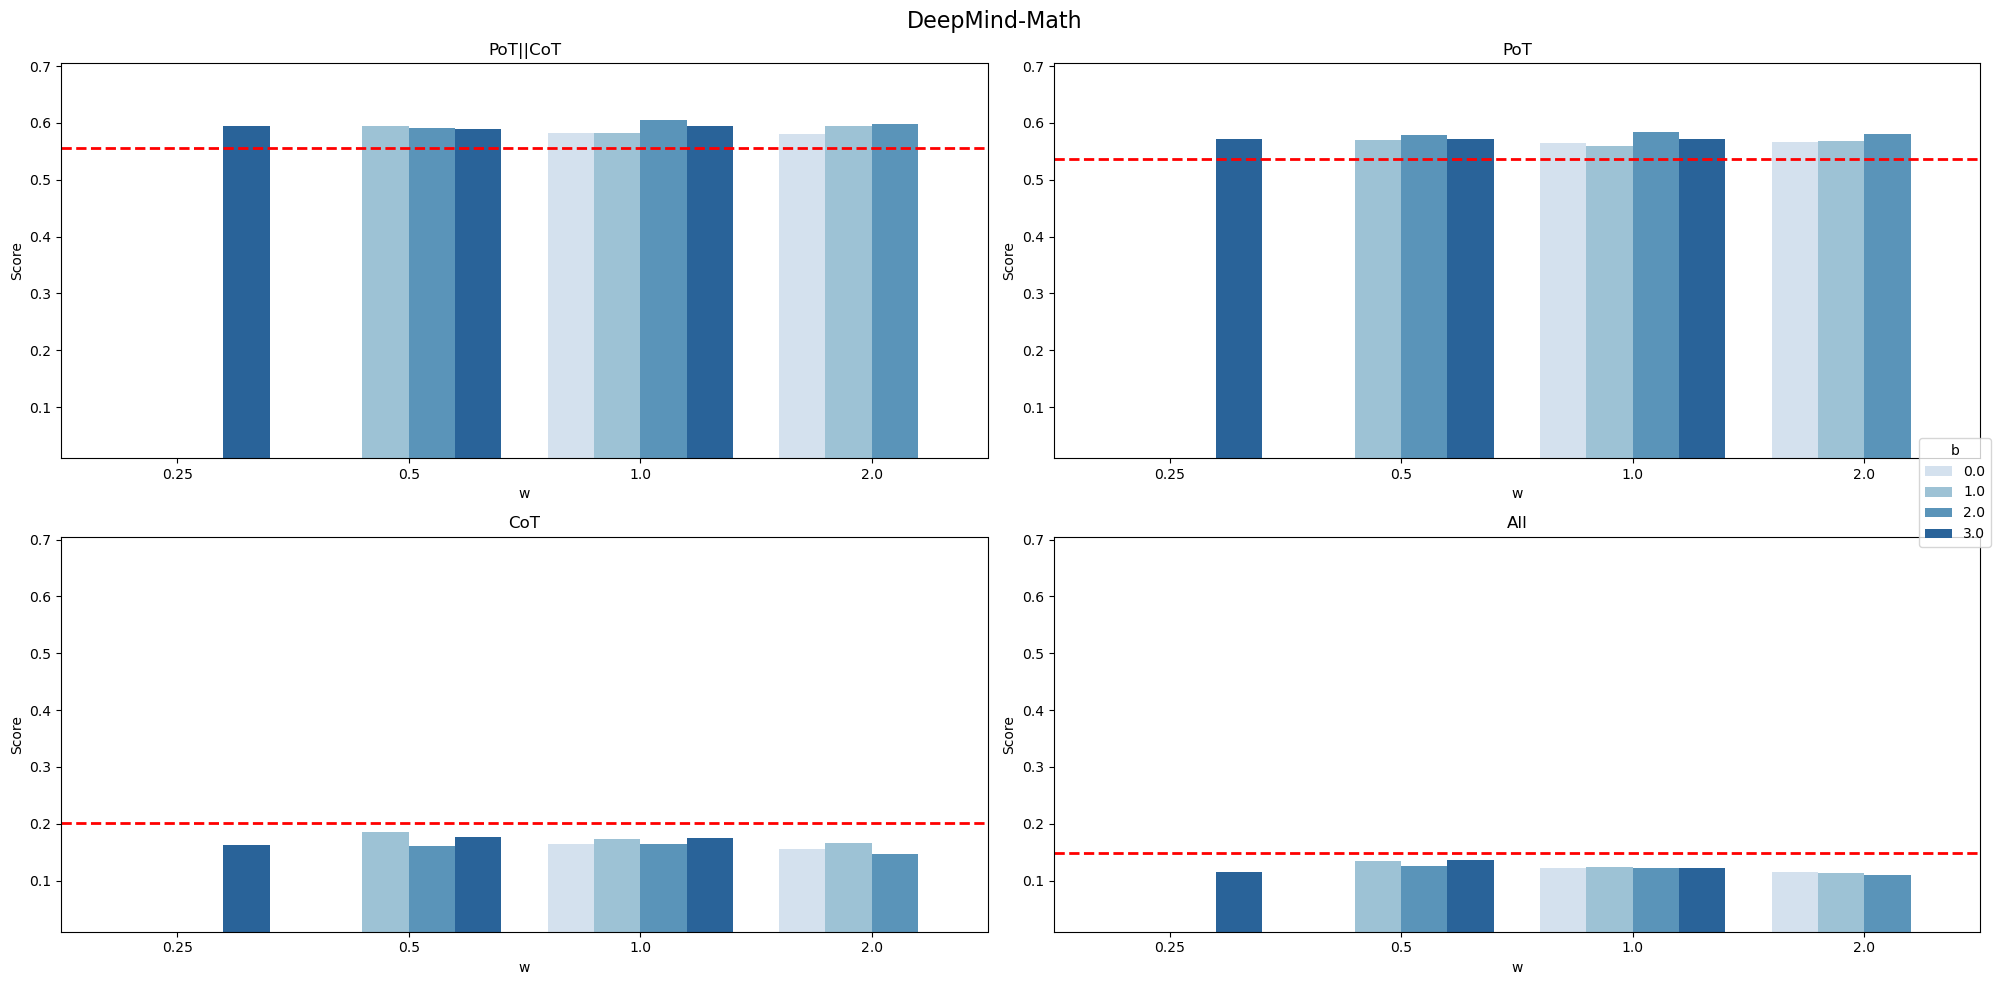

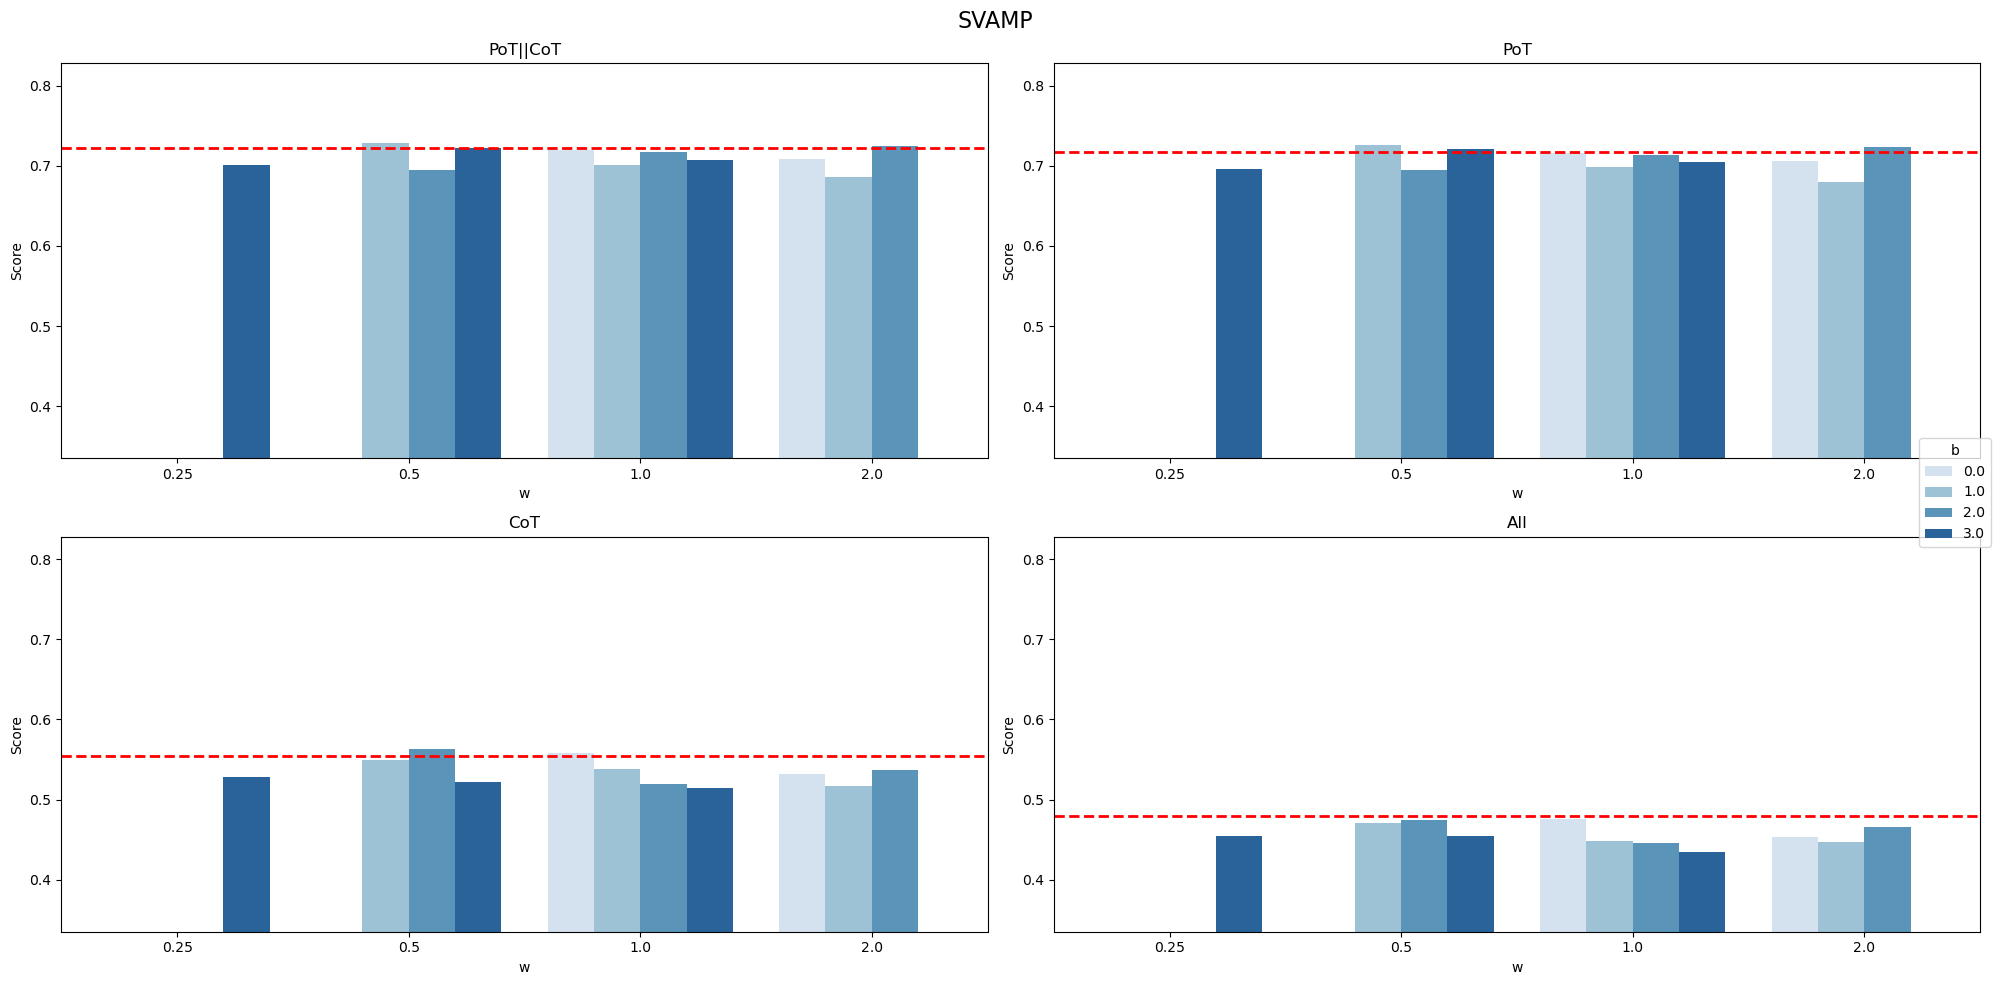

In [35]:
bench_name2id = {
    "MATH": "math",
    "GSM8K": "gsm8k",
    "AQuA": "aqua",
    "NumGLUE": "numglue",
    "MMLU-Math": "mmlu_mathematics",
    "SAT-Math": "sat",
    "DeepMind-Math": "deepmind",
    "SVAMP": "svamp",
}


def show_decoding_barplot_w_hue(bench_name):
    bench_id = bench_name2id[bench_name]

    plot_titles = ["PoT||CoT", "PoT", "CoT", "All"]
    interested_scores = ["fallback", "pot", "cot", "all"]
    interested_suffixes = [f"_{score.lower()}_correct" for score in interested_scores]
    interested_scores = [f"{bench_id}{suffix}" for suffix in interested_suffixes]

    bench_barplot_w_hue(bench_name, interested_scores, plot_titles, filtered_data)


for bench_name in bench_name2id.keys():
    show_decoding_barplot_w_hue(bench_name)